In [2]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

In [6]:
cwd = f"{os.getcwd()}/"
img_path = f"{cwd}data_/Images/"
pm_path = f"{cwd}data_/Pixel_masks/"


In [4]:
model = load_model('model_unet_trained_on_6x140.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


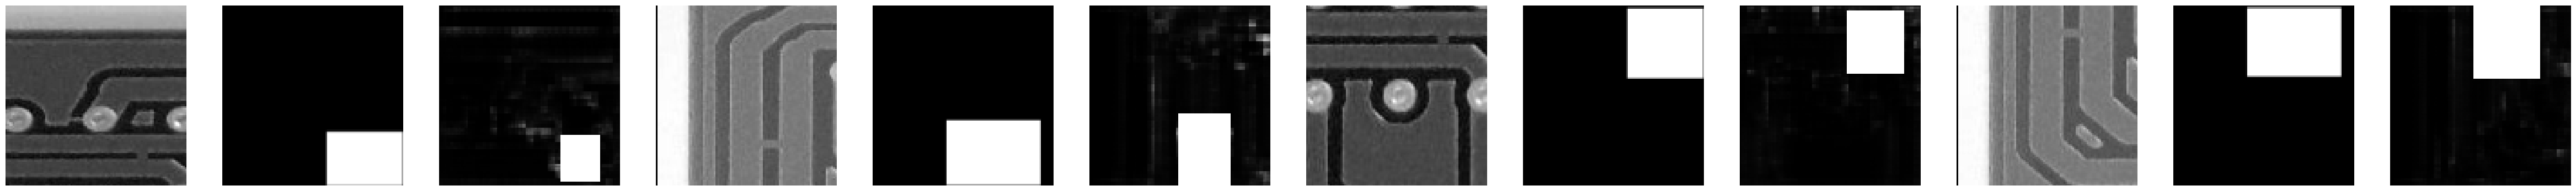

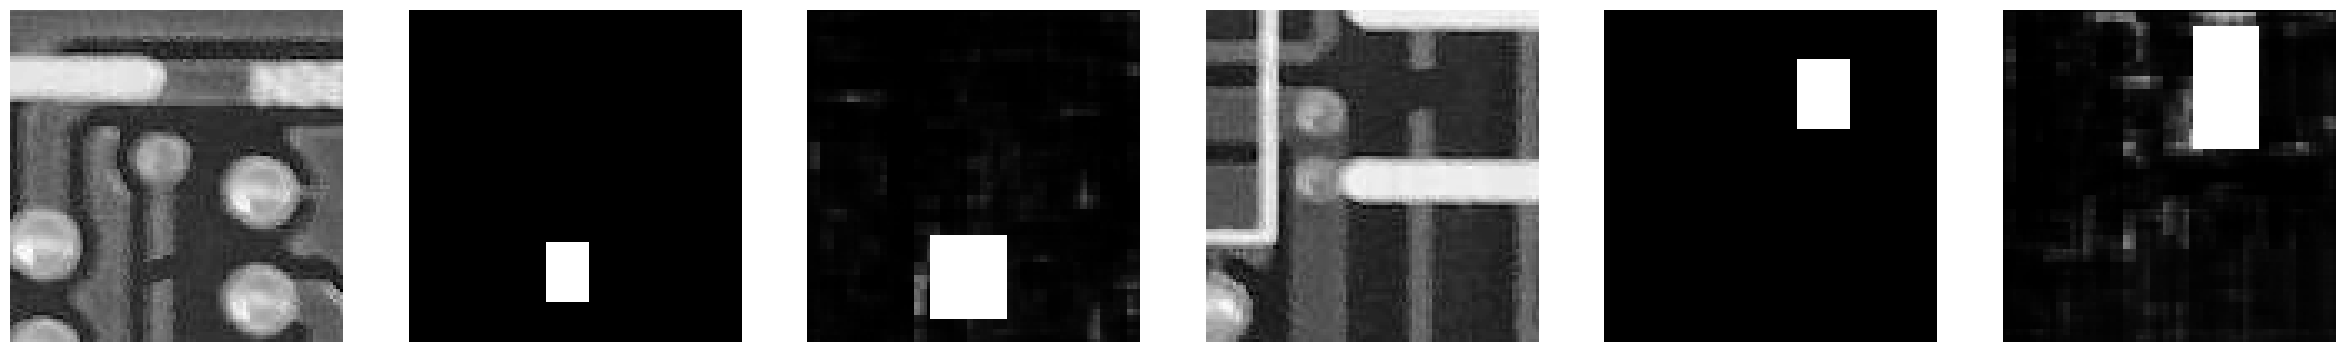

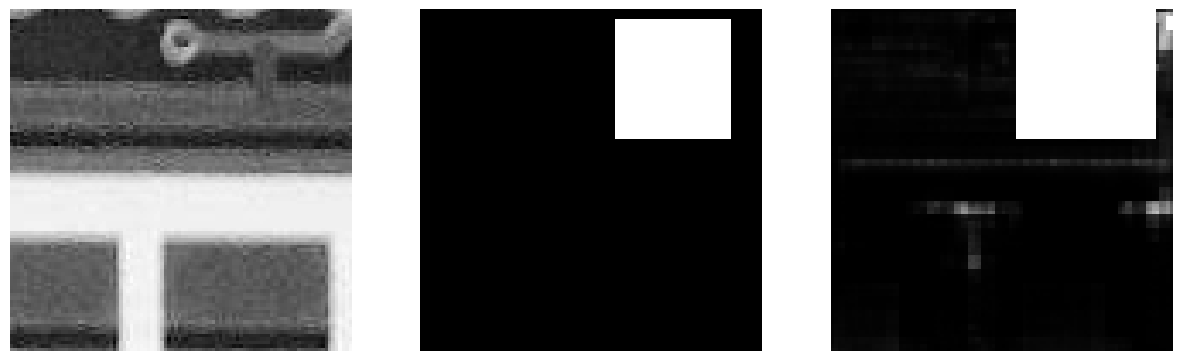

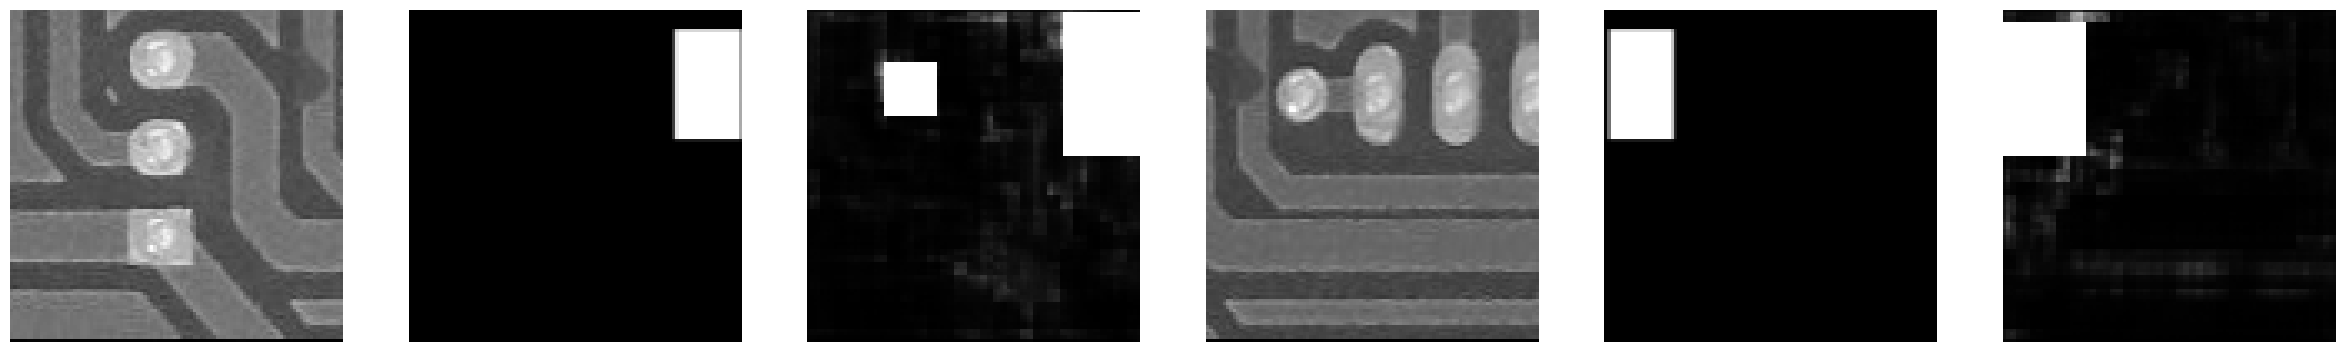

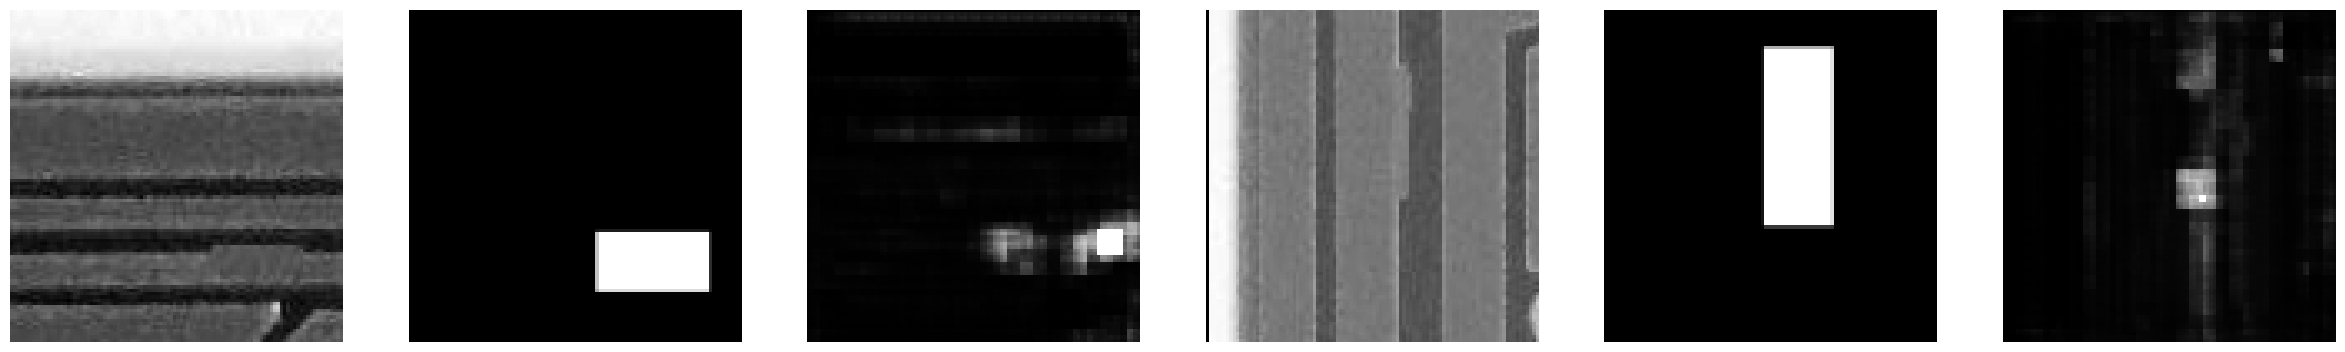

In [8]:
#np.random.seed(666)

rnd_file_names = np.random.choice(os.listdir(img_path), size=5)

for file_name in rnd_file_names:
    img = cv2.imread(f"{img_path}{file_name}")
    img = cv2.resize(img, (600,600))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    pm = cv2.imread(f"{pm_path}pm-{os.path.splitext(file_name)[0]}.png")
    pm = cv2.resize(pm, (600, 600))
    pm = cv2.cvtColor(pm, cv2.COLOR_BGR2GRAY)
    
    new_size = (100, 100)

    cropped_images = []
    cropped_masks = []
    cropped_class = []

    for y in range(0, 600, 100):
        for x in range(0, 600, 100):
            y0, x0 = y, x
            y100, x100 = y+100, x+100
            # if a bounding box crosses the cropping border, increase shift the corresponding border, so defects are not cut off
            while( np.any(pm[y0, x0:x100])) and (y0 != 0): 
                y0 -= 1
            while (np.any(pm[min(y100, 599), x0:x100])) and (y100 != 600):
                y100 += 1
            while( np.any(pm[y0:y100, x0])) and (x0 != 0):
                x0 -= 1
            while( np.any(pm[y0:y100, min(x100, 599)])) and (x100 != 600):
                x100 += 1
            img_patch = cv2.resize(img[y0:y100, x0:x100], (100, 100))
            pm_patch = cv2.resize(pm[y0:y100, x0:x100], (100, 100))
            if np.any(pm_patch):
                cropped_images.append(img_patch)
                cropped_masks.append(pm_patch)
                cropped_class.append(file_name)

    cropped_images = np.array(cropped_images)
    cropped_masks = np.array(cropped_masks)
    cropped_class = np.array(cropped_class)

    predictions = []
    predictions_rect = []

    for img_patch in cropped_images:
        img_4_pred = np.asarray(img_patch) / 255.0
        img_4_pred = np.expand_dims(img_4_pred, axis=0)
        pred = model.predict(img_4_pred)
        pred = pred * 255
        pred = pred.astype(np.uint8)
        pred = pred.squeeze()
        predictions.append(pred)

        _, pred_thresh = cv2.threshold(pred , 200, 255, type=cv2.THRESH_BINARY)
        cnt, hier = cv2.findContours(pred_thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)


        

        pred_rect = pred.copy()
        
        scale = 1.5
        for c in cnt:
            x, y, w, h = cv2.boundingRect(c)
            # Calculate new coordinates to extend the rectangle by 50%
            x50 = max(0, x - int(w * (scale-1)/2))  # 25% of width
            y50 = max(0, y - int(h * (scale-1)/2))  # 25% of height
            w50 = min(pred_rect.shape[1] - x50, int(w * scale))  # 50% increase in width
            h50 = min(pred_rect.shape[0] - y50, int(h * scale))  # 50% increase in height
            cv2.rectangle(pred_rect, (x50, y50), (x50+w50, y50+h50), 255, -1)
        
        predictions_rect.append(pred_rect)
        

    predictions = np.asarray(predictions)
    predictions_rect = np.asarray(predictions_rect)
    n = predictions.shape[0]

    fig, ax = plt.subplots(1, 3*n, figsize=(15*n, 15))
    for i, img, pm, pr in zip(range(len(ax)), cropped_images, cropped_masks, predictions_rect):
        ax[3*i].imshow(img, cmap='gray')
        ax[3*i].axis('off')
        ax[3*i+1].imshow(pm, cmap='gray')
        ax[3*i+1].axis('off')
        ax[3*i+2].imshow(pr, cmap='gray')
        ax[3*i+2].axis('off')


    
    